In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold
import time

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

In [2]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [3]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)


cpu


# Model definition

In [21]:
torch.manual_seed(0) #get the same random numbers everytime you run the code
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

t_span = (0, 10) #wanted timespan
n_step = 100 #number of steps to train the data (number of initial conditions)
n_data = 1000 #number of data per step (per initial condition, this number of datapoints to train, validate, test data)

#validation set will be used to choose hyperparameters, decide when to stop training, compare multiple models fairly and detect overfitting
train, validation, test = create_trainig_validation_test_set(harmonic_osc,
                                                             t_span=t_span,
                                                             n_steps=n_step,
                                                             n_data=n_data,
                                                             coeff_valtest=[0.699, 0.001, 0.3],
                                                             method="RK45",
                                                             device=device,
                                                             seed=0)

print(len(train['X']))
print(len(validation['X']))

699
1


In [22]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in, hidden_sizes, activation):
        super().__init__()
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }

        #allow for different sizes of neurons for each layer
        layer_sizes = [n_in] + hidden_sizes + [1] #becomes for example [4, 64, 32, 16, 1]
        
        self.net = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes)-1)
        ]) #nn.Linear(4, 64), nn.Linear(64, 32), ..., nn.Linear(16, 1)

        self.activation = act[activation] #chooses a value from the dictionary, e.g. act['tanh']

    def forward(self, x):
        for layer in self.net[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.net[-1](x)

# test model
model = HarmonicModel(
    n_in=4,
    hidden_sizes=[64, 32, 16],   # ← arbitrary shapes
    activation='tanh'
).to(device)

In [23]:
def loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)
    
    return mse_y

In [24]:
#train model
def train_harmonic(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)
    
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        loss = loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        """
        if (epoch+1) % (int(epochs)) == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
        """

    return model #return trained model, not final loss

#evaluate model
def evaluate_harmonic(model, data):
    model.eval()
    X_val = data["X"].to(device)
    y_val = data["y_tensor"][:, :, 0].to(device)

    t = X_val[:, :, 3]
    k = X_val[:, :, 0]
    x_00 = X_val[:, :, 1]
    x_01 = X_val[:, :, 2]

    with torch.no_grad():
        y_pred = model(X_val).squeeze(-1)
        loss = loss_harmonic(y_pred, y_val, x_00, x_01, t, k, N_f=1000)

    return loss.item()

# Hyperparameter optimization

## 1) Using random hyperparameter search

In [26]:
def rng_hparameters_search_kfold(
        n_trials,
        layers_i: tuple,
        neurons_i: tuple,
        activations_l: list,
        lr_i: tuple,
        data,
        n_splits=5,
        epochs=100,
        seed=0,
        device='cpu',
        show_progress: bool = False
    ):

    torch.manual_seed(seed)
    random.seed(seed)

    X_full = data["X"]
    y_full = data["y_tensor"][:, :, 0].to(device)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    results = []

    for trial in tqdm(range(n_trials), desc="Hyperparameter search with K-Fold"):

        # === Random sample of hyperparameters ===
        n_layers = random.randint(layers_i[0], layers_i[1])

        hidden_sizes = [
            random.randint(neurons_i[0], neurons_i[1])
            for _ in range(n_layers)
        ]

        activation = random.choice(activations_l)

        lr = 10 ** random.uniform(
            torch.log10(torch.tensor(lr_i[0])).item(),
            torch.log10(torch.tensor(lr_i[1])).item()
        )

        params = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'lr': lr
        }

        fold_losses = []

        # === K-FOLD LOOP ===
        for fold_id, (train_idx, val_idx) in enumerate(kf.split(X_full)):

            X_train = X_full[train_idx].to(device)
            y_train = y_full[train_idx]

            X_val = X_full[val_idx].to(device)
            y_val = y_full[val_idx]

            # New model every fold
            model = HarmonicModel(
                n_in=4,
                hidden_sizes=hidden_sizes,
                activation=activation
            ).to(device)

            # Rebuild data dicts expected by your functions
            train_data = {
                "X": X_train,
                "y_tensor": y_train.unsqueeze(-1)
            }

            val_data = {
                "X": X_val,
                "y_tensor": y_val.unsqueeze(-1)
            }

            # === Train ===
            train_harmonic(model, lr=lr, epochs=epochs, data=train_data)

            # === Validate ===
            val_loss = evaluate_harmonic(model, data=val_data)
            fold_losses.append(val_loss)

            # Free VRAM
            del model
            torch.cuda.empty_cache()
            if device != "cpu":
                torch.cuda.synchronize()

        avg_val_loss = sum(fold_losses) / len(fold_losses)

        # compute mean and variance
        mean_loss = float(np.mean(fold_losses))
        var_loss = float(np.var(fold_losses))

        if show_progress:
            print(f"\nTrial {trial+1} average CV Loss: {mean_loss:.6f}, Variance: {var_loss:.6f}")
            print("Parameters:", params)

        results.append({
            "params": params,
            "fold_losses": fold_losses,
            "mean_loss": mean_loss,
            "var_loss": var_loss
        })

    # sort by best loss
    results = sorted(results, key=lambda x: x["mean_loss"])

    return results


In [27]:
results_opt_rand = rng_hparameters_search_kfold(n_trials=10,
                                 layers_i=(2, 5),
                                 neurons_i=(16, 128),
                                 activations_l=['tanh', 'sine', 'gelu', 'relu'],
                                 lr_i=(1e-4, 1e-2),
                                 data=train,
                                 n_splits=5, 
                                 seed=0,
                                 device=device,
                                show_progress=True
                                 )

Hyperparameter search with K-Fold:  10%|█         | 1/10 [01:04<09:40, 64.51s/it]


Trial 1 average CV Loss: 0.440550, Variance: 0.000839
Parameters: {'hidden_sizes': [113, 69, 21, 49, 81], 'activation': 'relu', 'lr': 0.000645458426476286}


Hyperparameter search with K-Fold:  20%|██        | 2/10 [02:15<09:06, 68.31s/it]


Trial 2 average CV Loss: 0.617292, Variance: 0.001666
Parameters: {'hidden_sizes': [77, 61, 90, 43], 'activation': 'sine', 'lr': 0.00036616403801840433}


Hyperparameter search with K-Fold:  30%|███       | 3/10 [03:12<07:21, 63.14s/it]


Trial 3 average CV Loss: 0.194258, Variance: 0.001865
Parameters: {'hidden_sizes': [95, 118], 'activation': 'gelu', 'lr': 0.009430145683311597}


Hyperparameter search with K-Fold:  40%|████      | 4/10 [03:56<05:32, 55.42s/it]


Trial 4 average CV Loss: 0.317208, Variance: 0.008384
Parameters: {'hidden_sizes': [55, 28, 109], 'activation': 'tanh', 'lr': 0.006275908106915603}


Hyperparameter search with K-Fold:  50%|█████     | 5/10 [04:54<04:42, 56.50s/it]


Trial 5 average CV Loss: 0.649667, Variance: 0.006996
Parameters: {'hidden_sizes': [76, 87, 28, 61], 'activation': 'relu', 'lr': 0.00042893689042187375}


Hyperparameter search with K-Fold:  60%|██████    | 6/10 [05:51<03:46, 56.60s/it]


Trial 6 average CV Loss: 0.805906, Variance: 0.002912
Parameters: {'hidden_sizes': [86, 77, 72], 'activation': 'gelu', 'lr': 0.00013321685484021884}


Hyperparameter search with K-Fold:  70%|███████   | 7/10 [06:19<02:21, 47.33s/it]


Trial 7 average CV Loss: 0.489537, Variance: 0.001521
Parameters: {'hidden_sizes': [27, 108], 'activation': 'relu', 'lr': 0.0026333394617191475}


Hyperparameter search with K-Fold:  80%|████████  | 8/10 [06:59<01:29, 44.95s/it]


Trial 8 average CV Loss: 0.707069, Variance: 0.001566
Parameters: {'hidden_sizes': [94, 79], 'activation': 'gelu', 'lr': 0.0003074834560288192}


Hyperparameter search with K-Fold:  90%|█████████ | 9/10 [08:15<00:54, 54.82s/it]


Trial 9 average CV Loss: 0.635702, Variance: 0.003194
Parameters: {'hidden_sizes': [106, 127, 24, 40], 'activation': 'sine', 'lr': 0.0003000764112372459}


Hyperparameter search with K-Fold: 100%|██████████| 10/10 [09:10<00:00, 55.06s/it]


Trial 10 average CV Loss: 0.727274, Variance: 0.002704
Parameters: {'hidden_sizes': [118, 85, 73], 'activation': 'tanh', 'lr': 0.000144841040863984}


## 2) Using Bayesian hyperparameter search

In [28]:
# Define your hyperparameter ranges and data
layers_i = (2, 5)
neurons_i = (4, 128)
activations_l = ['tanh', 'sine', 'gelu', 'relu']
lr_i = (1e-4, 1e-2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective_kfold(trial, layers_i, neurons_i, activations_l, lr_i, data, n_splits=5, epochs=100, show_progress=False, device='cpu'):
    
    # ===== Sample hyperparameters =====
    n_layers = trial.suggest_int("n_layers", layers_i[0], layers_i[1])
    hidden_sizes = [trial.suggest_int(f"neurons_l{i}", neurons_i[0], neurons_i[1]) for i in range(n_layers)]
    activation = trial.suggest_categorical("activation", activations_l)
    lr = trial.suggest_float("lr", lr_i[0], lr_i[1], log=True)

    X_full = data["X"]
    y_full = data["y_tensor"][:, :, 0].to(device)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_losses = []

    # ===== K-Fold loop =====
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_full)):

        X_train = X_full[train_idx].to(device)
        y_train = y_full[train_idx]

        X_val = X_full[val_idx].to(device)
        y_val = y_full[val_idx]

        # build new model each fold
        model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)

        # build data dicts for your training functions
        train_data_fold = {"X": X_train, "y_tensor": y_train.unsqueeze(-1)}
        val_data_fold   = {"X": X_val, "y_tensor": y_val.unsqueeze(-1)}

        # ===== Train =====
        train_harmonic(model, lr=lr, epochs=epochs, data=train_data_fold)

        # ===== Validate =====
        val_loss = evaluate_harmonic(model, data=val_data_fold)
        fold_losses.append(val_loss)

        # Free memory
        del model
        torch.cuda.empty_cache()
        if device != "cpu":
            torch.cuda.synchronize()

    # average over folds
    mean_loss = float(np.mean(fold_losses))
    var_loss = float(np.var(fold_losses))

    if show_progress:
        print(f"\nTrial average CV Loss: {mean_loss:.6f}, Variance: {var_loss:.6f}")

    # Optuna only minimizes mean loss
    return mean_loss

# Use functools.partial to pass extra arguments
objective_fixed = functools.partial(objective_kfold,
                                    layers_i=layers_i,
                                    neurons_i=neurons_i,
                                    activations_l=activations_l,
                                    lr_i=lr_i,
                                    data=train,
                                    n_splits=5,
                                    epochs=100,
                                    show_progress=True, 
                                    )

study = optuna.create_study(direction="minimize")
study.optimize(objective_fixed, n_trials=10)


[I 2025-12-05 14:38:34,439] A new study created in memory with name: no-name-3ec9376f-b006-4e3a-853d-6a73de36ab65


[I 2025-12-05 14:39:42,975] Trial 0 finished with value: 0.7833356499671936 and parameters: {'n_layers': 5, 'neurons_l0': 24, 'neurons_l1': 23, 'neurons_l2': 25, 'neurons_l3': 86, 'neurons_l4': 124, 'activation': 'sine', 'lr': 0.00012312926593819308}. Best is trial 0 with value: 0.7833356499671936.



Trial average CV Loss: 0.783336, Variance: 0.003675


[I 2025-12-05 14:40:26,906] Trial 1 finished with value: 0.8241274356842041 and parameters: {'n_layers': 5, 'neurons_l0': 67, 'neurons_l1': 66, 'neurons_l2': 44, 'neurons_l3': 34, 'neurons_l4': 11, 'activation': 'gelu', 'lr': 0.0002316506331038168}. Best is trial 0 with value: 0.7833356499671936.



Trial average CV Loss: 0.824127, Variance: 0.006342


[I 2025-12-05 14:41:18,932] Trial 2 finished with value: 0.06183317229151726 and parameters: {'n_layers': 5, 'neurons_l0': 96, 'neurons_l1': 94, 'neurons_l2': 27, 'neurons_l3': 18, 'neurons_l4': 31, 'activation': 'tanh', 'lr': 0.006835452640558653}. Best is trial 2 with value: 0.06183317229151726.



Trial average CV Loss: 0.061833, Variance: 0.000103


[I 2025-12-05 14:42:02,355] Trial 3 finished with value: 0.7355949759483338 and parameters: {'n_layers': 3, 'neurons_l0': 62, 'neurons_l1': 43, 'neurons_l2': 77, 'activation': 'sine', 'lr': 0.00020189470856813016}. Best is trial 2 with value: 0.06183317229151726.



Trial average CV Loss: 0.735595, Variance: 0.007326


[I 2025-12-05 14:42:52,662] Trial 4 finished with value: 0.8579856514930725 and parameters: {'n_layers': 5, 'neurons_l0': 95, 'neurons_l1': 41, 'neurons_l2': 12, 'neurons_l3': 21, 'neurons_l4': 88, 'activation': 'gelu', 'lr': 0.00021741942435378578}. Best is trial 2 with value: 0.06183317229151726.



Trial average CV Loss: 0.857986, Variance: 0.007411


[I 2025-12-05 14:43:26,738] Trial 5 finished with value: 0.3650305688381195 and parameters: {'n_layers': 4, 'neurons_l0': 64, 'neurons_l1': 41, 'neurons_l2': 44, 'neurons_l3': 53, 'activation': 'relu', 'lr': 0.0011376861711280054}. Best is trial 2 with value: 0.06183317229151726.



Trial average CV Loss: 0.365031, Variance: 0.001738


[I 2025-12-05 14:44:27,447] Trial 6 finished with value: 0.6626466870307922 and parameters: {'n_layers': 5, 'neurons_l0': 113, 'neurons_l1': 60, 'neurons_l2': 58, 'neurons_l3': 21, 'neurons_l4': 42, 'activation': 'tanh', 'lr': 0.00036048535096707784}. Best is trial 2 with value: 0.06183317229151726.



Trial average CV Loss: 0.662647, Variance: 0.002360


[I 2025-12-05 14:45:59,539] Trial 7 finished with value: 0.19757813811302186 and parameters: {'n_layers': 5, 'neurons_l0': 119, 'neurons_l1': 71, 'neurons_l2': 72, 'neurons_l3': 57, 'neurons_l4': 101, 'activation': 'relu', 'lr': 0.0010345194269769883}. Best is trial 2 with value: 0.06183317229151726.



Trial average CV Loss: 0.197578, Variance: 0.000868


[I 2025-12-05 14:46:48,003] Trial 8 finished with value: 0.13382015824317933 and parameters: {'n_layers': 4, 'neurons_l0': 16, 'neurons_l1': 77, 'neurons_l2': 45, 'neurons_l3': 103, 'activation': 'gelu', 'lr': 0.004136454799849129}. Best is trial 2 with value: 0.06183317229151726.



Trial average CV Loss: 0.133820, Variance: 0.003565


[I 2025-12-05 14:46:57,814] Trial 9 finished with value: 0.31259411871433257 and parameters: {'n_layers': 2, 'neurons_l0': 9, 'neurons_l1': 36, 'activation': 'gelu', 'lr': 0.00970480991407021}. Best is trial 2 with value: 0.06183317229151726.



Trial average CV Loss: 0.312594, Variance: 0.007203


In [ ]:
#for Random search
best_params, best_loss = results_opt_rand[0]["params"], results_opt_rand[0]["mean_loss"]

#For Bayesian search
hidden_sizes_opt_bayes = [study.best_params[k] for k in sorted(study.best_params) if k.startswith('neurons_l')]

#Choose best model type (based on validation loss of the K-fold CV)
if study.best_value > best_loss:
    best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])
else:
    best_params = study.best_params
    best_params = {
    'n_layers': best_params['n_layers'],
    'hidden_sizes': hidden_sizes_opt_bayes,
    'activation': best_params['activation'],
    'lr': best_params['lr']
    }    

# Test best hyperparameters

In [35]:
best_model = HarmonicModel(n_in=4,
                           hidden_sizes=best_params["hidden_sizes"],
                           activation=best_params["activation"]).to(device)

In [36]:
# Train the best model
train_harmonic(best_model, lr=best_params["lr"], epochs=1000, data=train)

HarmonicModel(
  (net): ModuleList(
    (0): Linear(in_features=4, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=94, bias=True)
    (2): Linear(in_features=94, out_features=27, bias=True)
    (3): Linear(in_features=27, out_features=18, bias=True)
    (4): Linear(in_features=18, out_features=31, bias=True)
    (5): Linear(in_features=31, out_features=1, bias=True)
  )
  (activation): Tanh()
)

In [37]:
#evaluate
loss_opt = evaluate_harmonic(best_model, data=test)
print(f"The validation loss on the optimized model is {loss_opt}")

The validation loss on the optimized model is 0.007822082377970219


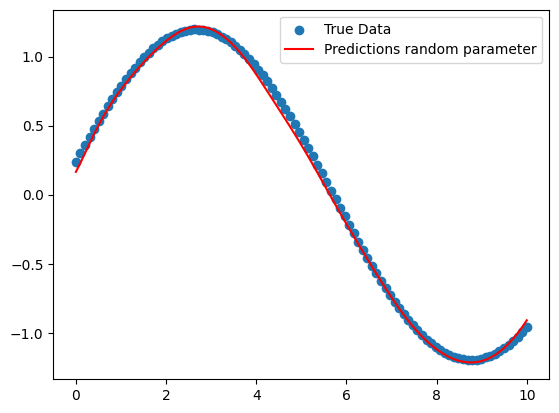

In [39]:
#Look at performance on test data
X = test["X"]

y_pred_opt = best_model(X).squeeze(-1)

n = 110 #defines which initial conditions we look at?
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred_opt.cpu().detach()[n], color="red", label="Predictions random parameter")
plt.legend()
plt.show()

# Test the model on noisy data

In [ ]:
def add_noise_to_dataset(dataset, tensor_keys=['y_tensor'], noise_std=0.05, seed=None):
    """
    Add Gaussian noise to specified tensors in a dataset.

    Args:
        dataset (dict): Dictionary of tensors, e.g., {'y_tensor': ..., 't_tensor': ...}
        tensor_keys (list): Which tensors to add noise to (usually target/output tensors)
        noise_std (float): Standard deviation of Gaussian noise
        seed (int, optional): Random seed for reproducibility
    Returns:
        noisy_dataset (dict): Copy of dataset with added noise
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    noisy_dataset = {k: v.clone() for k, v in dataset.items()}  # copy original tensors
    
    for key in tensor_keys:
        noisy_dataset[key] += torch.randn_like(dataset[key]) * noise_std
    
    return noisy_dataset

In [41]:
#Noisy data (create only 1 set to check the model performances)
train_no_noise, validation_no_noise, test_no_noise = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1, [0.699, 0.001, 0.3], "RK45", device=device, seed=0)

# Example: add noise with std=0.1 to y_tensor
noise_std = 0.5
train_noise = add_noise_to_dataset(train_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
validation_noise = add_noise_to_dataset(validation_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
test_noise = add_noise_to_dataset(test_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)

# test dataset bayes
X = test_noise["X"]
y_pred_noise = best_model(X).squeeze(-1)


test_loss_bayes_noise = evaluate_harmonic(best_model, data=test_noise)
print(f"Test Loss Random optimization: {test_loss_bayes_noise:.4f}")

Test Loss Random optimization: 0.1966


/tmp/ipykernel_32229/1405275027.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


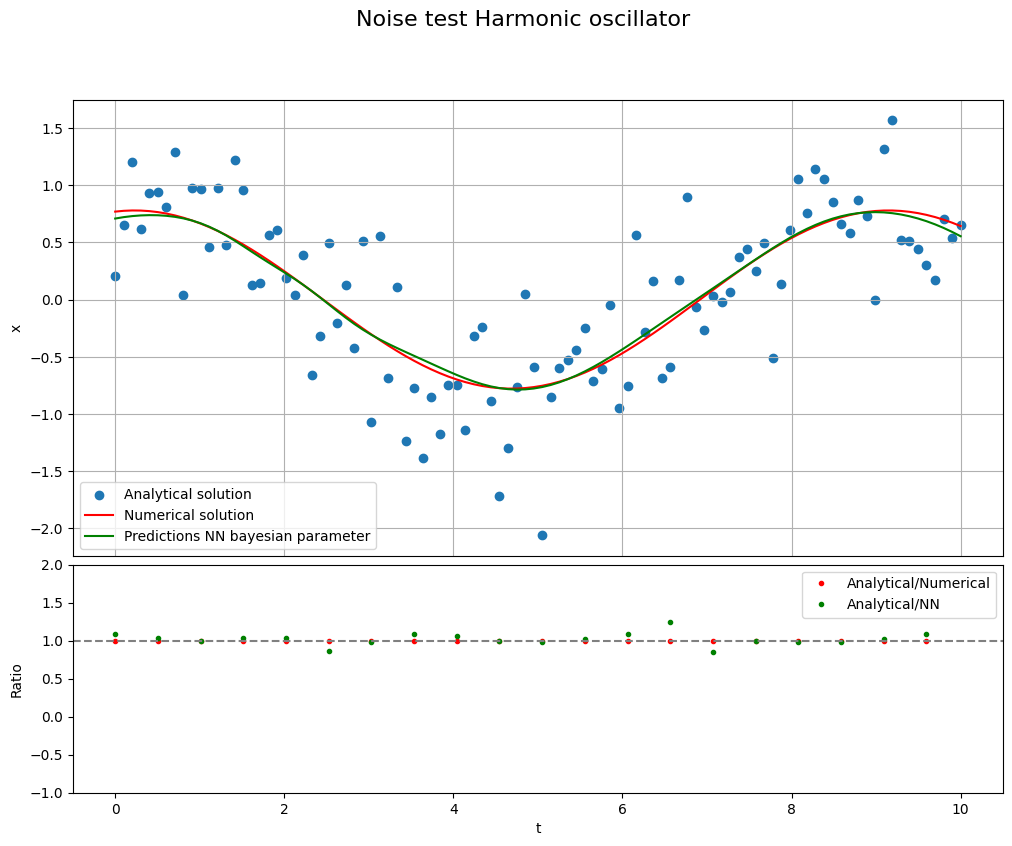

In [42]:
n = 0

y_pred_noise.to("cpu")
test_noise["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_noise["x0_tensor"][n][0], test_noise["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_noise["t_tensor"][n][0], test_noise["t_tensor"][n][-1]
w = test_noise["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_noise["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_no_noise["y_tensor"][n][0:, 0]/y_pred_noise.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_noise["t_tensor"][n], test_noise["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_noise["t_tensor"][n], y_pred_noise.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Noise test Harmonic oscillator", fontsize=16)
plt.show()

# Test generalization

In [48]:
#Generalization
train_generalization, validation_generalization, test_generalization = create_trainig_validation_test_set(harmonic_osc, (0, 50), 200, 1, [0.699, 0.001, 0.3], "RK45", device=device, seed=0)
# test dataset bayes
X = test_generalization["X"]
y_pred_generalization = best_model(X).squeeze(-1)


test_loss_bayes_generalization = evaluate_harmonic(best_model, data=test_generalization)
print(f"Test Loss Random optimization: {test_loss_bayes_generalization:.4f}")

Test Loss Random optimization: 1.0062


/tmp/ipykernel_32229/2674055991.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


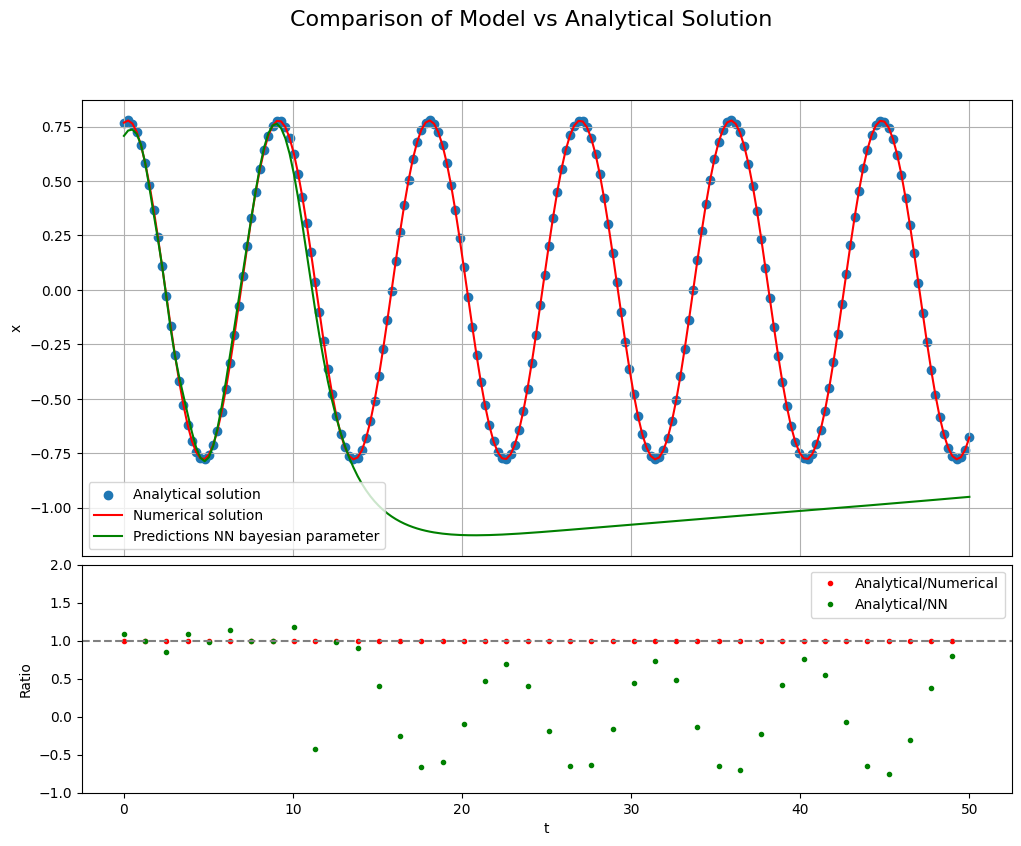

In [49]:
n = 0

y_pred_generalization.to("cpu")
test_generalization["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
w = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_generalization["y_tensor"][n][0:, 0]/y_pred_generalization.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_generalization["t_tensor"][n], test_generalization["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_generalization["t_tensor"][n], y_pred_generalization.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Comparison of Model vs Analytical Solution", fontsize=16)
plt.show()

# Test physical quantities

### Energy conservation

Initial energy E0 = 1.290926e-01
Max absolute deviation = 1.861316e-01
Max relative deviation = 1.441845e+00


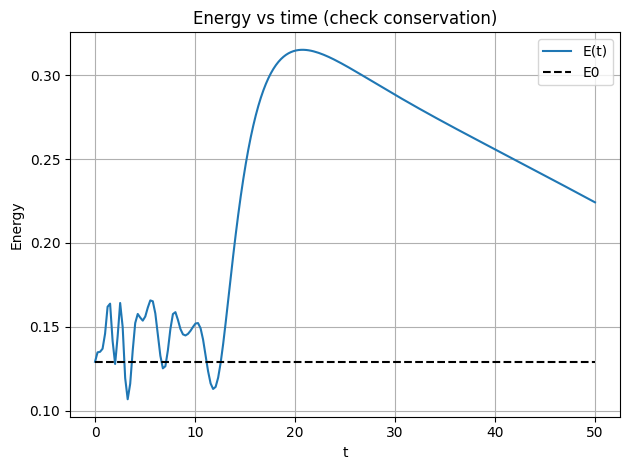

In [50]:
n = 0  # choose trajectory index

# Position
x = y_pred_generalization[n].detach().cpu().numpy()

# Time
t = test_generalization["t_tensor"][n].detach().cpu().numpy()

# Velocity via finite difference
v = np.gradient(x, t)

#Energy conservation (check on generalized data)
E_t = 0.5 * v**2 + 0.5 * float(w) * x**2
E0 = E_t[0]

# diagnostics
abs_dev = np.max(np.abs(E_t - E0))
rel_dev = np.max(np.abs((E_t - E0) / E0))

print(f"Initial energy E0 = {E0:.6e}")
print(f"Max absolute deviation = {abs_dev:.6e}")
print(f"Max relative deviation = {rel_dev:.6e}")

plt.plot(test_generalization["t_tensor"][n], E_t, label='E(t)')
plt.hlines(E0, sol.t[0], sol.t[-1], colors='k', linestyles='dashed', label='E0')
#plt.ylim(0,2)
plt.xlabel('t')
plt.ylabel('Energy')
plt.title('Energy vs time (check conservation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
n=0

#Computation time
N = 200
timesteps_NN = np.zeros(N)
timesteps_Num = np.zeros(N)
N_list = np.arange(0,N)

X = test["X"][n]
y0 = [test["x0_tensor"][n][0], test["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test["t_tensor"][n][0], test["t_tensor"][n][-1]
w = test["args_tensor"][n]

#NN
for i, el in tqdm(enumerate(N_list), desc="Computation time NN: "):
    begin = time.perf_counter()
    for _ in range(el):
        best_model(X)
    end = time.perf_counter()
    timesteps_NN[i] = end-begin

#Numerical
for i, el in tqdm(enumerate(N_list), desc="Computation time Numerical: "):
    begin = time.perf_counter()
    for _ in range(el):
        sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test["t_tensor"][n], method='RK45', args=(w))
    end = time.perf_counter()
    timesteps_Num[i] = end-begin

Computation time NN: : 200it [00:07, 28.42it/s]
Computation time Numerical: : 200it [01:18,  2.54it/s]


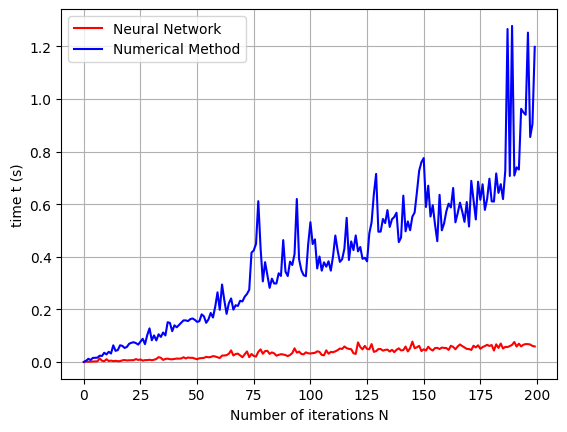

In [47]:
#Plot computational time
plt.plot(N_list, timesteps_NN, color='red', label="Neural Network")
plt.plot(N_list, timesteps_Num, color='blue', label="Numerical Method")
plt.xlabel("Number of iterations N")
plt.ylabel("time t (s)")
plt.grid(True)
plt.legend()
plt.show()

# TO DO

- Fix energy (doesn't look good)
- Make sure both models are comparable
- Compare both models